In [1]:
from pyawd import VectorAcousticWaveDataset2D, VectorAcousticWaveDataset3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
import pandas as pd

sns.set_theme()

In [2]:
train_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/train2D")
train_dataset._display_velocity_model = True
X = np.load("../../../local/datasets/AWD/train2D_interrogators_data.npy")
X = X[:, 0, :, :, :]
Y = np.load("../../../local/datasets/AWD/train2D_epicenters.npy")
test_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/test2D")
test_dataset._display_velocity_model = True
X_test = np.load("../../../local/datasets/AWD/test2D_interrogators_data.npy")
X_test = X_test[:, 0, :, :, :]
Y_test = np.load("../../../local/datasets/AWD/test2D_epicenters.npy")

In [3]:
def make_df(X):
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    for i in range(X.shape[0]):
        for j in range(X.shape[-1]):
            a.append(i)
            b.append(j*train_dataset.ddt)
            c.append(X[i, 0, 0, j])
            d.append(X[i, 0, 1, j])
            e.append(X[i, 1, 0, j])
            f.append(X[i, 1, 1, j])
    df = pd.DataFrame()
    df["id"] = a
    df["time"] = b
    df["x0"] = c
    df["y0"] = d
    df["x1"] = e
    df["y1"] = f
    return df

In [4]:
Y = Y[:, 1]
Y_test = Y_test[:, 1]

In [5]:
df, df_test = make_df(X), make_df(X_test)

In [45]:
train = tsfresh.extract_features(df, column_id="id", column_sort="time", 
                                 default_fc_parameters=MinimalFCParameters()).dropna(axis=1)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.25it/s]


In [46]:
test = tsfresh.extract_features(df_test, column_id="id", column_sort="time", 
                                default_fc_parameters=MinimalFCParameters()).dropna(axis=1)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.60it/s]


In [47]:
print("Training size:", len(train))
print("Testing size:", len(test))

Training size: 1000
Testing size: 200


In [48]:
train_targets = Y
train_features = train
test_targets = Y_test
test_features = test

In [49]:
train_features_numeric = train_features.select_dtypes(include=[np.number])
test_features_numeric = test_features.select_dtypes(include=[np.number])

In [50]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_features_numeric)

In [52]:
normalized_train_features_numeric = scaler.transform(train_features_numeric)
normalized_train_targets = normalize(train_targets)
normalized_test_features_numeric = scaler.transform(test_features_numeric)
normalized_test_targets = normalize(test_targets)

In [53]:
print("Numeric features:", len(train_features_numeric.columns))

Numeric features: 40


In [54]:
print("Minimal target:", np.min(train_targets))
print("Maximal target:", np.max(train_targets))
print("Mean target:", np.mean(train_targets))
print("Median target:", np.median(train_targets))

Minimal target: -1.0
Maximal target: 0.9375
Mean target: -0.052875
Median target: -0.0625


## Error function

In [55]:
def rmse(y, y_hat):
    return np.mean((y-y_hat)**2)**0.5

## Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
linear_model = LinearRegression().fit(normalized_train_features_numeric, normalized_train_targets)

In [58]:
%%capture lm_res
print("RMSE Linear Model:", rmse(normalized_test_targets, linear_model.predict(normalized_test_features_numeric)))

## Neural Network

In [59]:
from sklearn.neural_network import MLPRegressor

In [60]:
mlp_regressor = MLPRegressor(solver='adam',
                             activation='logistic',
                             hidden_layer_sizes=(32, 16, 8),
                             max_iter=10000,
                             learning_rate_init=0.01
                            ).fit(normalized_train_features_numeric, normalized_train_targets)

In [61]:
%%capture nn_res
print("RMSE Neural Network:", rmse(normalized_test_targets, mlp_regressor.predict(normalized_test_features_numeric)))

## SGD

In [62]:
from sklearn.linear_model import SGDRegressor

In [63]:
sgd = SGDRegressor(loss="squared_error", penalty="l2").fit(normalized_train_features_numeric, normalized_train_targets)

In [64]:
%%capture sgd_res
print("RMSE SGD:", rmse(normalized_test_targets, sgd.predict(normalized_test_features_numeric)))

## Support Vector Machines

In [65]:
from sklearn import svm

In [66]:
svm = svm.SVR().fit(normalized_train_features_numeric, normalized_train_targets)

In [67]:
%%capture svm_res
print("RMSE SVM:", rmse(normalized_test_targets, svm.predict(normalized_test_features_numeric)))

## PLS regression

In [68]:
from sklearn.cross_decomposition import PLSRegression

In [69]:
pls2 = PLSRegression(n_components=2).fit(normalized_train_features_numeric, normalized_train_targets)

In [70]:
%%capture pls_res
print("RMSE PLS:", rmse(normalized_test_targets, pls2.predict(normalized_test_features_numeric)))

## Decision Tree

In [71]:
from sklearn import tree

In [72]:
dt = tree.DecisionTreeRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [73]:
%%capture dt_res
print("RMSE Decision Tree:", rmse(normalized_test_targets, dt.predict(normalized_test_features_numeric)))

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
rf = RandomForestRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [76]:
%%capture rf_res
print("RMSE Random Forest:", rmse(normalized_test_targets, rf.predict(normalized_test_features_numeric)))

## AdaBoost

In [77]:
from sklearn.ensemble import AdaBoostRegressor

In [78]:
ada_boost = AdaBoostRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [79]:
%%capture ada_res
print("RMSE Ada Boost:", rmse(normalized_test_targets, ada_boost.predict(normalized_test_features_numeric)))

## Results

In [80]:
print(lm_res, end="")
print(nn_res, end="")
print(sgd_res, end="")
print(svm_res, end="")
print(pls_res, end="")
print(dt_res, end="")
print(rf_res, end="")
print(ada_res, end="")

RMSE Linear Model: 0.28139379533461695
RMSE Neural Network: 0.11070025085944522
RMSE SGD: 0.2188680661816679
RMSE SVM: 0.11688581856579987
RMSE PLS: 0.2168621725582156
RMSE Decision Tree: 0.13142934701589265
RMSE Random Forest: 0.10018880978761913
RMSE Ada Boost: 0.11448287248565019


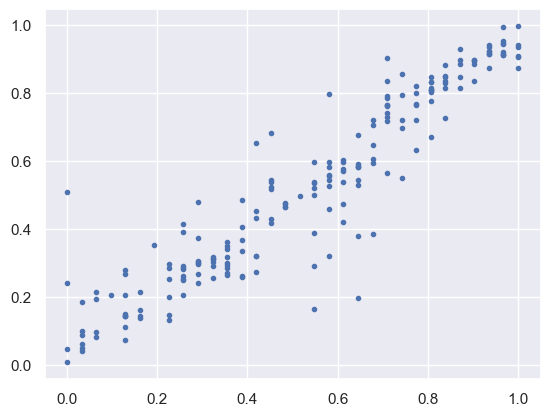

In [81]:
plt.scatter(normalized_test_targets, rf.predict(normalized_test_features_numeric), marker='.')